In [2]:
!jt -t onedork
!pwd
%matplotlib inline
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interpolate
from scipy.stats import norm
import sys
sys.path.append('..')  # Allows us to import local files.

jtplot.style(theme='monokai')
plt.rcParams.update({
    "text.usetex": True,
    "axes.labelsize": 20,
    "axes.labelweight": "bold",
    "axes.titlesize": 20,
    "axes.titleweight": "bold",
    "figure.titlesize": 25,
    "figure.titleweight": "bold",
    "font.family": "sans-serif",
    "font.sans-serif": ["Calibri"],
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,})

px = 1/plt.rcParams['figure.dpi']

/cygdrive/c/Users/colli/Desktop/Git/PythonFinanceLibrary/src/StochasticProcesses


# Introduction to Hull-White / Vasicek

Note that both *Hull-White* and *Vasicek* are referenced in the title above. This is because there is a significant amount of ambiguity in the literature between the two and it is easy to miss a great deal of useful information if you focus on just the one and not the other during exploratory reading.

## The Model

<div style="background: #61afef;
            border-radius: 10px;
            color: #1d1e23;
            horizontal-align: middle;
            margin: auto;
            padding: 10px 30px 10px 10px;
            text-align: center;
            width: 60%;">
$$
\mathrm{d}r(t) = \left( \theta(t) - \alpha r(t)\right)\mathrm{d}t + \sigma(t) \mathrm{d} W(t)
$$
</div>

* $\theta(t)$ the mean reversion level (i.e. $\lim\limits_{t\rightarrow\infty} r(t) = \theta(t)$).
* $\alpha$ the mean reversion speed (i.e. the rate at which $r(t)$ converges to $\theta(t)$).
* $\sigma(t)$ the volatility which may be constant (for pricing exotics, such as Bermudan swaptions, it needs a term structure).

There seems to be a lack of literature targeted at practitioners (the usual measure theoretic nonsense of academics is in no short supply) and that which does exist is often contradictory.

The questions we seek to address here are:

1. How to discretise the model for simulation.
1. How to concisely price swaptions using Hull-White.
1. How to use aforementioned swaption prices for calibration.

### Shortcomings

1. Hull-White does not model the term structure of interest rate curves, unlike the HJM or LMM models, therefore it does not account for correlation between points on the curve. Thus, if an instrument payoff depends on multiple forward rates, such as an Asian style interest rate option, HW will be inadequate to model it.
    * Note that Hull-White is just a special case of the HJM model.
2. Unlike LMM, HW simulates a *fictitious* short rate which is not actually observable in the market. This makes it more difficult to calibrate.

### Statistics

The mean and the variance of the short rate $r(t)$ are given below:

$$
\mathbb{E}[r(t)] = r(0)e^{-\alpha t} + f(0,t) + \frac{\sigma^2}{2\alpha^2}\left(1 - e^{-\alpha t}\right)^2 - \left(r(0) + \frac{\sigma^2}{2\alpha^2}\right)e^{-\alpha t}
$$


$$
\mathbb{Var}[r(t)] = \frac{\sigma^2}{2\alpha}\left(1 - e^{-2 \alpha t}\right)
$$

## Model Parameters

It is empirically evident that HW, although non-linear in both $\alpha$ and $\sigma$ is more *non-linear* in $\alpha$. Though the notion of what we mean by *more non-linear* here is not made quantitatively precise it is hoped that the reader appreciates the intention.

### Mean Reversion Speed: $\alpha$

I would argue that there are pairs of values $(\alpha, \sigma)$ which yield the same model. If the vol increases substantially one should be able to offset it with a significantly higher mean reversion speed.

### Mean Reversion Level: $\theta(t)$

It can be shown that $\theta(t)$ needs to satisfy the following relationship with regards to the instantaneous forward curve:

<div style="background: #61afef;
            border-radius: 10px;
            color: #1d1e23;
            horizontal-align: middle;
            margin: auto;
            padding: 10px 30px 10px 10px;
            text-align: center;
            width: 60%;">

$$
    \theta(t) = \alpha f(0,t) + \frac{\partial f(0,t)}{\partial t} + \frac{\sigma^2}{2\alpha}\left(1 - e^{-2\alpha t}\right)
$$
</div>

Let us consider some of the consequences of this equation and focus on each of the terms in more depth.

1. Clearly $\theta(t) \propto \sigma$. The manner in which $\theta(t)$ depends on $\alpha$ is more complicated and explored further below.
1. The second term means that the forward curve needs to be continuous in the first derivative (given an example of this failing to be the case).

First let us consider the third term, $\frac{\sigma^2}{2\alpha}$, which is independent of the forward curve $f(0,t)$.

c:\users\colli\desktop\git\pythonfinancelibrary\venv\lib\site-packages\IPython\core\events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
c:\users\colli\desktop\git\pythonfinancelibrary\venv\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


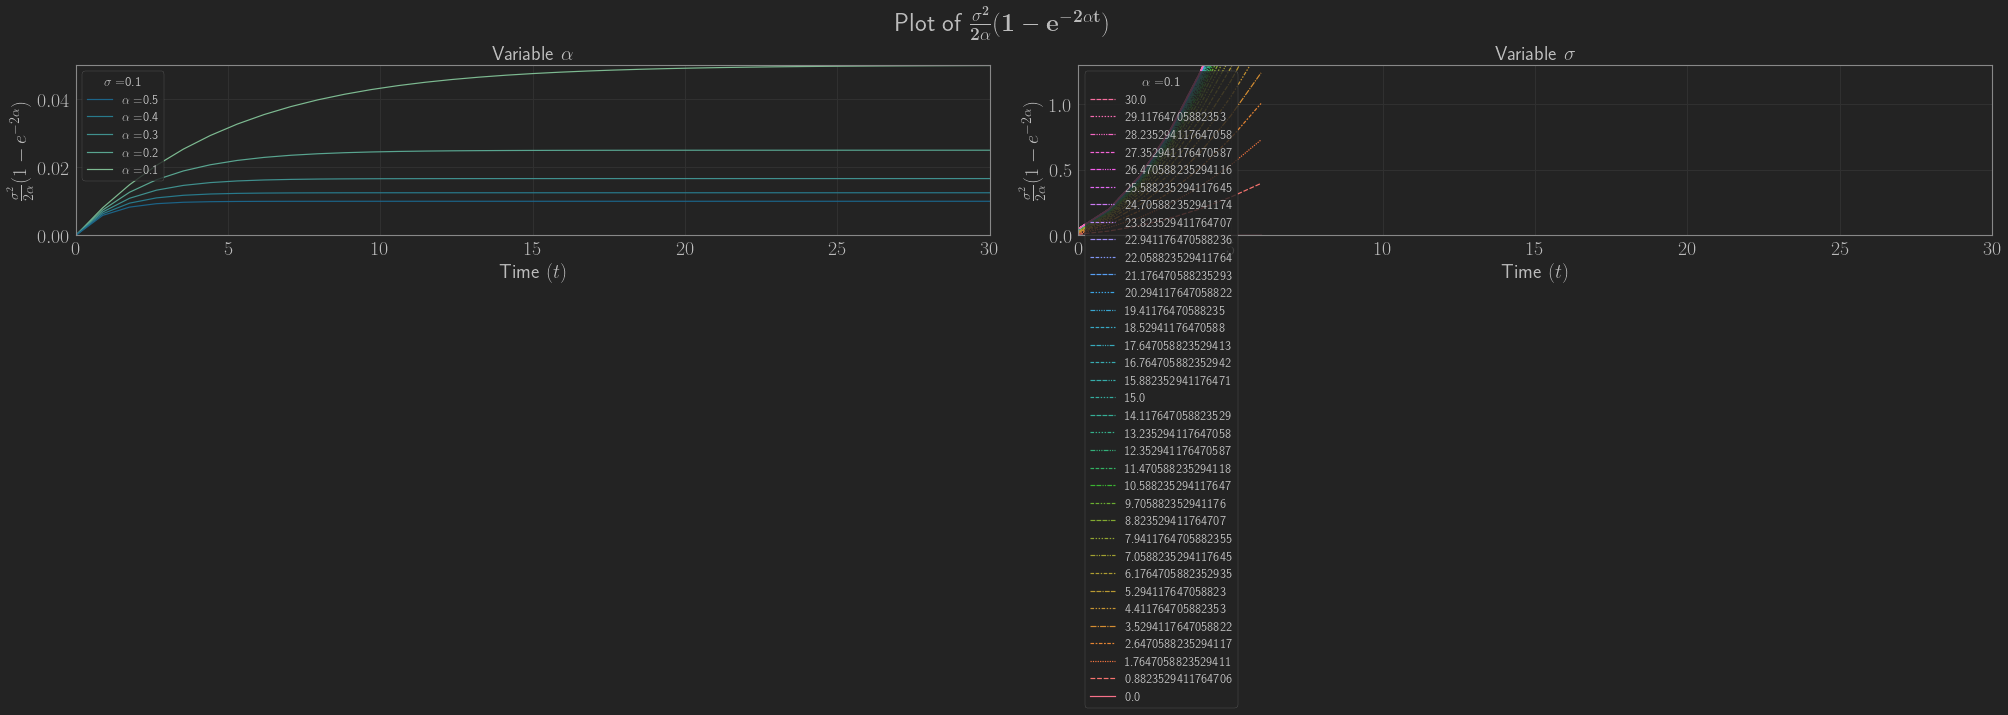

In [22]:
#sns.set_palette("crest")
cmap = sns.color_palette('Reds')
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(2000*px, 500*px))

fig.suptitle(r'Plot of $\mathbf{\frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha t})}$')


t = np.linspace(0.0, 30.0, 35)

sigma = 0.1
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    third_term = (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=third_term, ax=ax1, label=r'$\alpha=$' + str(alpha), palette=cmap)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], title=r'$\sigma=$'+str(sigma), loc='upper left')
ax1.set_title(r'Variable $\alpha$')
ax1.set_xlabel(r'Time $(t)$')
ax1.set_ylabel(r'$\frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha})$')
ax1.set_xlim(0, 30)
ax1.set_ylim(0, 0.05)

alpha = 0.1
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
third_term_2 = np.zeros([len(sigmas), len(t)])
for i in range(0, 7):
    third_term_2[i, :] = (sigmas[i]**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))

third_term_to_plot = pd.DataFrame(data=third_term_2, columns=t)
sns.lineplot(data=third_term_to_plot)  #x=t, y=third_term_2, ax=ax2)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], title=r'$\alpha=$' + str(alpha), loc='upper left')
ax2.set_title(r'Variable $\sigma$')
ax2.set_xlabel(r'Time $(t)$')
ax2.set_ylabel(r'$\frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha})$')
ax2.set_xlim(0, 30)
_ = ax2.set_ylim(0, 1.3)



#### Constant Forward Curve

Clearly if the forward curve is constant then

>$\frac{\partial f(0,t)}{\partial t}=0$,

>$\lim\limits_{t \rightarrow \infty} \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha t}) = \frac{\sigma^2}{2\alpha}$

>$\lim\limits_{t \rightarrow \infty} \theta(t) = \alpha f(0,t) + \frac{\sigma^2}{2 \alpha}$.
In other words we can see for the simple case of the forward curve being flat/constant $\theta(t)$ and hence $r(t)$ does not simply converge to the initial forward curve.

In general, I would argue that $\lim\limits_{t\rightarrow\infty}\frac{\partial f(0,t)}{\partial t}=0$ assuming the forward curve flattens out in the long run.
Perhaps insert some examples of this.

Note in both cases below r = 0.1 yet the long term behaviour of $\theta(t)$ is far from that.

In [ ]:
t = np.linspace(0, 30, 31)
r = np.zeros(31) + 0.1

alpha = 0.1
sigma = 0.3

px = 1/plt.rcParams['figure.dpi']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1000*px, 500*px), constrained_layout=True)

dr = np.diff(r)
dr = np.append(dr, dr[-1])

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, ax=ax1, label=f'{alpha=}')  # So basically the third term dominates for a constant curve

ax1.legend(loc='upper left', title='sigma=0.3')

alpha = 0.1
for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, ax=ax2, label=f'{sigma=}')

ax2.legend(loc='upper left', title=r'$\alpha=0.1$')

In [ ]:
# Increasing swap curve
r = np.linspace(0.05, 0.15, 31)
t = np.linspace(0, 30, 31)

dr = np.diff(r)
dr = np.append(dr, dr[-1])

sigma = 0.1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1000*px, 500*px))

for alpha in [0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.30]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{alpha=}', ax=ax1)

ax1.legend(loc='upper left', title=r'$\sigma=0.3$')

alpha = 0.01

for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{sigma=}', ax=ax2)

ax2.legend(loc='upper left', title=r'$\alpha=0.1$')


In [ ]:
t = np.linspace(0, 30, 31)
r = np.linspace(0.15, 0.05, 31)

dr = np.diff(r)
dr = np.append(dr, dr[-1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1000*px, 500*px), constrained_layout=True)
sigma = 0.1
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{alpha=}', ax=ax1)

ax1.legend(loc='upper left', title=r'$\sigma=0.3$')

alpha = 0.1
for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{alpha=}')

ax2.legend(loc='upper left', title=r'$\alpha=0.1$')

## Simulation

### Decomposition into Stochastic and Deterministic Components

It is common practice (Brigo, Ostrovski et al.) to decompose the Hull-White SDE into a stochastic and deterministic component.

$$
r(t) = x(t) + \phi(t)
$$

* $x(t)$ is the stochastic component,
* $\phi(t)$ is the deterministic component.

#### Deterministic Component

$$
\phi(t) = f(0, t) + \frac{\sigma^2}{2\alpha^2}(1 - e^{-\alpha t})^2
$$

#### Stochastic Component (Ornstein-Uhlenbeck Process)
The SDE for $x(t)$ is given by:
$$
\mathrm{d}x(t) = -\alpha x(t) \mathrm{d}t + \sigma \mathrm{d}W(t), \; x(0) = 0 
$$

* Note Ostrovski makes a mistake in his paper and omits $\mathrm{d}t$ in the above.
* This is just an Ornstein-Uhlenbeck process and hence Gaussian/Normal (unsurpringly since HW is itself a Gaussian process).
* (Aside) In physics an Ornstein-Uhlenbeck process is often written as a Langevin equation of the form:
$$
\frac{\mathrm{d}x(t)}{\mathrm{d}t} = -\alpha x(t) + \sigma \xi(t)
$$
Where $\xi(t)$ is the *noise term* a supposed derivative of $W(t)$.


$$
x(t) = x(s) + \int\limits_s^t x(y) \mathrm{d}y, \; x(0) = 0
$$

We assume $x(s)$ is known i.e. we have simulated $x$ up to time $s$.

\begin{align}
    x(t_{i+1}) - x(t_i) &= -\alpha x(t_i) + \sigma \sqrt{\Delta t} Z \\
    x(t_{i+1}) &= (1 - \alpha) x(t_i) + \sigma \sqrt{\Delta t} Z \label{eq:discretised_x}
\end{align}

$$
Z \sim \mathcal{N}(0,1)
$$


#### Simulation via Joint Distribution
We could just use the discretised form above to simulate the process but that would result in some numerical approximations. Ostrovski goes one step further and shows how to simulate $x(t)$ and $\int\limits_s^t x(y) \mathrm{d}y$ as a system of coupled random variates.

## Discretization Approaches
$$
\mathrm{d}x(t) = -\alpha x(t) \mathrm{d}t + \sigma \mathrm{d}W(t), \; x(0) = 0
$$

From Ostrovski, Green, and Brigo and Mercurio we have via Euler-Maruyama:

$$
x(t_{i+1}) = (1 - \alpha \Delta t) x(t_i) + \sigma Z \sqrt{\Delta t}
$$

Green also has the following in his discussion on historical calibration

\begin{equation}
x_{i+1} = e^{-\alpha \Delta t} x_i + \sqrt{\frac{1 - e^{-2\alpha \Delta t}}{2\alpha}}
\end{equation}

But if we approximate:

\begin{equation}
e^{-x} \approx 1 - x
\end{equation}

Then we recover the discretisation at the top.

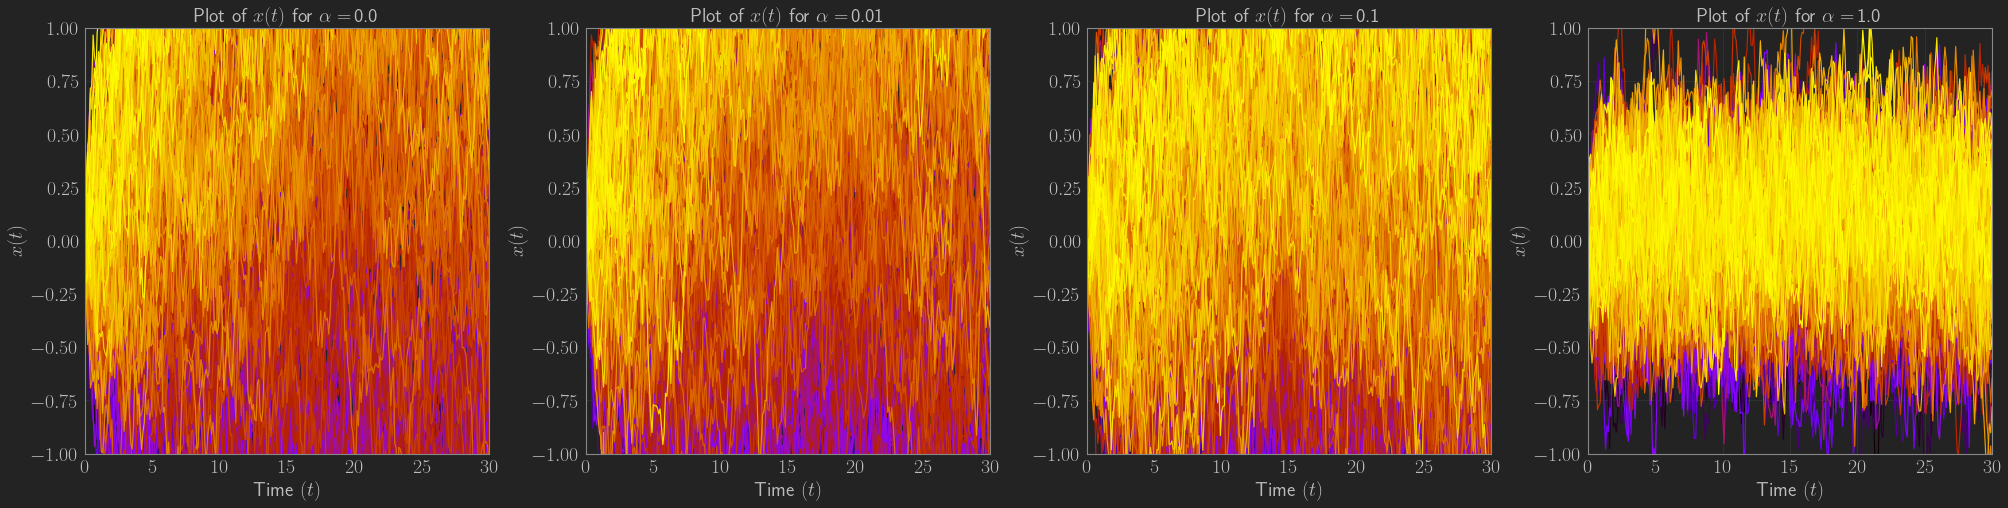

In [11]:
def plot_process(axis, t, hw_process, alpha):
    sorted_hw_process = hw_process[:, np.argsort(np.average(hw_process, 0))]
    for j in range(0, hw_process.shape[1]):
        sns.lineplot(x=t, y=sorted_hw_process[:,j], ax=axis, legend=False, dashes=False)
    axis.set_title(r'Plot of $x(t)$ for $\alpha=\,$' + str(alpha))
    axis.set_xlabel(r'Time $(t)$')
    axis.set_ylabel(r'$x(t)$')
    axis.set_xlim(0, maturity)
    _ = axis.set_ylim(-1, 1)

def hull_white_generator(alpha, sigma, maturity, dt, path_count):
    time_step_count = int(maturity/dt)
    t = np.array([i * dt for i in range(0, time_step_count + 1)])
    hw = np.zeros([time_step_count + 1, path_count])
    for i in range(0, time_step_count):
        hw[i+1,:] = (1 - alpha*dt)*hw[i,:] + sigma * np.sqrt(dt) * np.random.standard_normal(path_count)
    return (t, hw)

path_count=250
sigma=0.4
maturity=30
dt=0.1

hw1_alpha=0.00
hw2_alpha=0.01
hw3_alpha=0.10
hw4_alpha=1.00

hw1 = hull_white_generator(alpha=hw1_alpha, sigma=sigma, maturity=maturity, dt=dt, path_count=path_count)
hw2 = hull_white_generator(alpha=hw2_alpha, sigma=sigma, maturity=maturity, dt=dt, path_count=path_count)
hw3 = hull_white_generator(alpha=hw3_alpha, sigma=sigma, maturity=maturity, dt=dt, path_count=path_count)
hw4 = hull_white_generator(alpha=hw4_alpha, sigma=sigma, maturity=maturity, dt=dt, path_count=path_count)
palette = sns.color_palette('winter', n_colors=path_count)
sns.set_palette('gnuplot', n_colors=path_count)
fig, ax = plt.subplots(1, 4, figsize=(2000*px, 500*px), constrained_layout=True)
plot_process(axis=ax[0], t=hw1[0], hw_process=hw1[1], alpha=hw1_alpha)
plot_process(axis=ax[1], t=hw2[0], hw_process=hw2[1], alpha=hw2_alpha)
plot_process(axis=ax[2], t=hw3[0], hw_process=hw3[1], alpha=hw3_alpha)
plot_process(axis=ax[3], t=hw4[0], hw_process=hw4[1], alpha=hw4_alpha)

## Risk Neutral Calibration
Here we consider calibration to market instruments and hence calibration to market implied volatilities.

### Swaption Pricing

For a payer swaption we have the following Black-like formula for pricing. Note that for the most part we follow the notation of Brigo & Mercurio and only deviate for clarity.
$$
\textrm{PS}(N, K, \sigma_{\alpha, \beta}) = N \textrm{Bl}(K, S_{\alpha, \beta}(0), \sigma_{\alpha,\beta}) \sum_{i=\alpha+1}^\beta \tau_i P(0,T_i)
$$

Where Black's pricing formula is given by:
$$
\textrm{Bl}(K,F,\sigma,T) = F\Phi(d_1) - K\Phi(d_2)
$$

$$
d_1 = \frac{\ln\left(\frac{F}{K}\right) + \frac{1}{2}\sigma^2 T}{\sigma\sqrt{T}}
$$

$$
d_2 = \frac{\ln\left(\frac{F}{K}\right) - \frac{1}{2}\sigma^2 T}{\sigma\sqrt{T}}
$$

Where $F$ denotes the relevant forward price and $K$ the relevant strike. All other symbols should be self explanatory.

In order to calibrate the volatility term in Hull-White we need some instrument in the market which provides us with an implied volatility.
Sources may include swaptions, caps, and/or floors.

* It seems to be suggested that (see pg 20 of Brigo et al) that correlation plays an important role in pricing swaptions, but only a two factor Hull-White model can accommodate correlation yet they still calibrate Hull-White one factor using swaptions in numerous papers.
* Jamshidian's *trick* of decomposing a European swaption into a portfolio of bond options does not work for more than one factor.
* Green suggests assuming the volatility term structure is piecewise constant.

$$
B(t, T) = \frac{1}{\alpha}\left( 1 - e^{-\alpha (T - t)}\right)
$$

#### Green's Approximation

Green makes the following approximation 

<font color="red">In what way, whatsoever are the vols in the swaption vol cube even remotely similar to those calibrated to HW?</font>

In [18]:
from Curves import Curve
from scipy.stats import norm
from scipy.interpolate import interpolate

def B(t, T, alpha):
    return 1/alpha * (1 - np.exp(-alpha * (T - t))) 

def Black(T, H, V, curve):
    b0 = 1
    d1 = np.log(H)/(b0 * V) + 0.5 * V
    d2 = d1 - V
    return curve.get_discount_factors(T)*(H*norm.cdf(d1) - b0*norm.cdf(d2))

def Sigma(t, K, sigma_tenors, sigmas, curve, swap_payment_tenors, alpha):
    
    n = len(swap_payment_tenors)
    b = np.zeros(n)
    b[0] = 1
    b[-1] = 1 + K * (swap_payment_tenors[-1] - swap_payment_tenors[-2])
    for i in range(1, n-1):
        b[i] = K*(swap_payment_tenors[i] - swap_payment_tenors[i-1])
    
    dfs = curve.get__forward_discount_factors(t, swap_payment_tenors)
    numerator = 0   
    denominator = 0
    for i in range(0, n):
        numerator += b[i] * (B(t, swap_payment_tenors[i], alpha) - B(t, swap_payment_tenors[-1], alpha))*dfs[i]
        denominator += b[i]*dfs[i] 
        
    sigma_interpolator = interpolate.interp1d(sigma_tenors, sigmas, kind='previous')
    
    return dfs

tenors=[0.25, 0.5, 0.75, 1.0]
discount_factors=[0.99, 0.985, 0.9825, 0.980]
curve = Curve.Curve(tenors=tenors, discount_factors=discount_factors)

#print(Black(5, 0.02, 0.2, curve))
print(Sigma(1, [0.25, 0.5, 0.75, 1.0], [0.99, 0.985, 0.9825, 0.980], curve, [0.25, 0.5, 0.75, 1.0], 0.1))



[0.99   0.985  0.9825 0.98  ]


## Real World Calibration
Here we consider calibration to historic time series and hence calibration to historic volatilities.

## Unit Tests
1. Observe behaviour of flat initial curve.
1. Observe behaviour of monotonically increasing initial curve.
1. Observe behaviour of monotonically decreasing initial curve.
1. Observe limiting behaviour of Hull-White as $\alpha\rightarrow 0$.
1. Observe limiting behaviour of Hull-White as $\sigma\rightarrow\infty$.
1. Test pricing of bond or FRA with several different vols to ensure they aren't dependent on the vol (as it should be if Hull-White has been implemented correctly).
1. Ensure statistics such as mean and standard deviation converge to correct values.

## References
1. **XVA: Credit, Funding, and Capital Valuation Adjustments**; Wiley Finance Series; *Andrew Green*
1. **Efficient and Exact Simulation of the Hull-White Model**; SSRN Electronic Journal https://www.researchgate.net/publication/262336369_Efficient_and_Exact_Simulation_of_the_Hull-White_Model; *Vladimir Ostrovski*
1. http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html
1. **Interest Rate Models - Theory and Practice: With Smile, Inlfation and Credit, Second Edition**; Springer; *Damiano Brigo & Fabio Mercurio*

# Future Reference as to Differences between Hull-White Implementations of US and Others

1. Discretisation scheme may be different
2. $\theta$ may be different


# TODO
1. Implement the naive approximation to the stochastic process
2. Implement Ostrovski method of stochastic process
3. Compare 1 and 2
4. Compare to Milstein and Euler-Maruyama
5. See what Brandimarte does in his book
6. Price a bond option using HW analytical formula
7. Price a bond option using HW Monte Carlo
8. Price a swaption using HW analytical formula
9. Price a swaption using HW Motne Carlo
10. Price a cap using HW analytical formula
11. Price a cap using HW Monte Carlo
12. Price a floor using HW analytical formula
13. Price a floor using HW Monte Carlo
14. My gut tells me HW is less well behaved in the short end of the ZAR swap curve where there is a bit of kink.

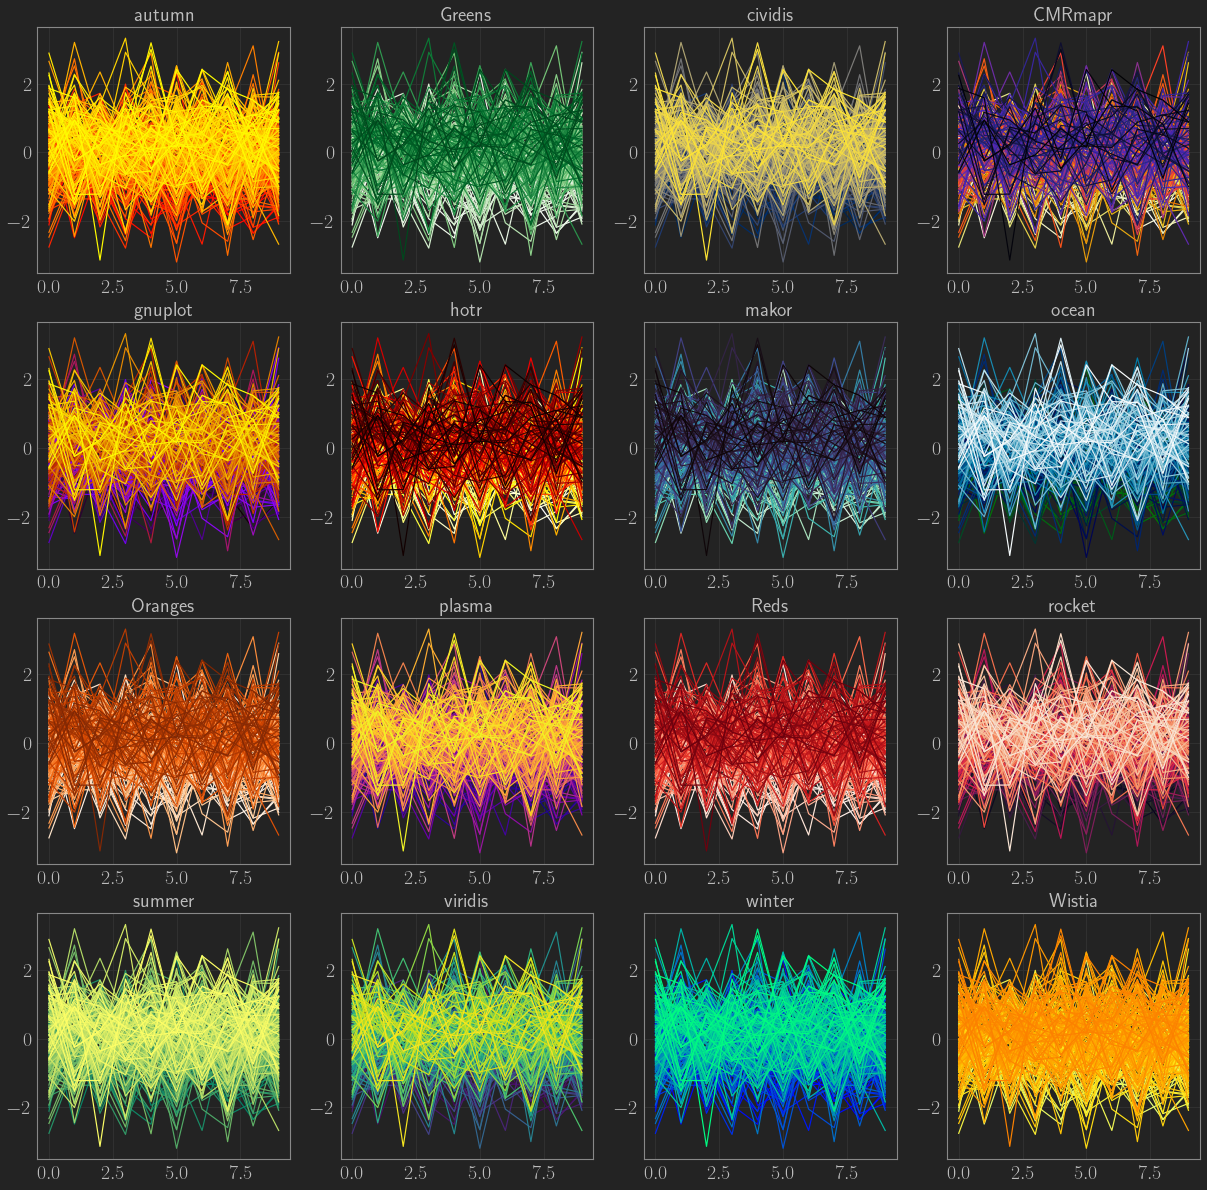

In [24]:
palettes =\
['autumn',
'Greens',
'cividis',
'CMRmap_r',
'gnuplot',
'hot_r',
'mako_r',
'ocean',
'Oranges',
'plasma',
'Reds',
'rocket',
'summer',
'viridis',
'winter',
'Wistia']

data = np.array(np.random.standard_normal([10, 200]))
df = pd.DataFrame(data=data)
df=df.reindex(df.mean().sort_values().index, axis=1)

data=data[:, np.argsort(np.average(data, 0))]
fig, axes = plt.subplots(4, 4, figsize=(1500*px, 1500*px))
for i in range(0, 4):
    for j in range(0, 4):
        sns.lineplot(data=data, ax=axes[i][j], palette=palettes[4*i+j], legend=False, dashes=False)
        palette_title = palettes[4*i+j].replace('_', '')
        axes[i][j].set_title(palette_title)